# Can CCG and SICBL be broken down into smaller sensible areas?

The short answer: no. Clinical Commissioning Groups (CCGs) and Sub-Integrated Care Board Locations can only be broken down into their constituent LSOAs (Lower Super Output Areas).

This notebook attempts to define CCGs and SICBLs by building up whole smaller regions including parishes and electoral wards.

The results are usually fairly good across the country, with most small regions building into a CCG or SICBL with no overlap with the neighbouring CCG or SICBL. However there is no one set of smaller regions that gives fully consistent boundaries for CCG and SICBL across all of England.

## Notebook setup

In [1]:
# For handling the tabular data:
import pandas as pd
# For maps:
import geopandas
import matplotlib.pyplot as plt

# For tracking paths to files:
import os
from dataclasses import dataclass

from mapclassify import greedy  # to assign colours to regions on map.
                                # ^ also requires libpysal.

In [2]:
# Define file paths
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    # Directories:
    dir_ons_geojson = '../data_geojson/ons_data/'
    dir_output_images = 'output_images'

    # Boundaries data:
    # LSOA:
    lsoa11_geojson = 'LSOA_Dec_2011_Boundaries_Generalised_Clipped_BGC_EW_V3.geojson'
    
    # CCGs:
    ccg15_geojson = 'Clinical_Commissioning_Groups_July_2015_GCB_in_England_2022.geojson'

    # SICBLs:
    sicbl22_geojson = 'SICBL_JUL_2022_EN_BGC.geojson'

    # Parishes:
    parish15_geojson = 'PARNCP_Dec_2015_GCB_in_England_and_Wales_V2_2022.geojson'
    parish20_geojson = 'Parishes_and_Non_Civil_Parished_Areas_Dec_2020_EW_BGC_V2_2022.geojson'

    # Wards:
    ward11_geojson = 'Wards_December_2011_GCB_EW_2022.geojson'
    cmward11_geojson = 'CMWD_Dec_2011_GCB_in_England_and_Wales_2022.geojson'
    ward15_geojson = 'Wards_December_2015_GCB_in_Great_Britain_2022.geojson'
    ward21_geojson = 'Wards_December_2021_GB_BGC_2022.geojson'

    # Output:
    image_ccg15_ward11 = 'boundaries_ccg15_ward11.png'
    image_ccg15_cmward11 = 'boundaries_ccg15_cmward11.png'
    image_ccg15_ward15 = 'boundaries_ccg15_ward15.png'
    image_ccg15_parish15 = 'boundaries_ccg15_parish15.png'
    image_sicbl22_parish20 = 'boundaries_sicbl22_parish20.png'
    image_sicbl22_ward21 = 'boundaries_sicbl22_ward21.png'
    image_ccg15_lsoa11 = 'boundaries_ccg15_lsoa11.png'

paths = Paths()

## Define a function for data processing

The following function creates new columns in the GeoDataFrames. It finds which big region contains each small region, and assigns the same colour to all small regions in each big region.

In [3]:
def prepare_data_for_maps(
        gdf_big_regions,
        gdf_small_regions,
        col_big_regions,
        col_small_regions
    ):

    # Prevent pandas shenanigans:
    gdf_big_regions = gdf_big_regions.copy()
    gdf_small_regions = gdf_small_regions.copy()

    # Split any small region MultiPolygon into their Polygons:
    gdf_small_regions = gdf_small_regions.explode()
    # Find small region centroids and representative points:
    gdf_small_regions['centroid'] = gdf_small_regions['geometry'].centroid
    gdf_small_regions['representative_point'] = (
        gdf_small_regions['geometry'].representative_point())
    
    # --- Find containment ---
    # For each small region point, check if each big polygon contains it.
    # Create a dictionary of which big region contains each small region:
    dict_contains = {}
    
    for ind in gdf_small_regions.index:
        series_bool = gdf_big_regions['geometry'].contains(
            gdf_small_regions.loc[ind, 'representative_point'])
        
        big_ind = series_bool[series_bool == True].index
        try:
            big_name = gdf_big_regions.loc[big_ind, col_big_regions].values[0]
            small_name = gdf_small_regions.loc[ind, col_small_regions]
            
            dict_contains[small_name] = big_name
        except IndexError:
            # This point isn't in any big regions.
            # (e.g. point in Scotland, big regions only England).
            pass
    # Turn the dictionary into a Series:
    series_contains = pd.Series(dict_contains)
    series_contains.index.name = col_small_regions
    series_contains.name = col_big_regions

    # Merge the containment series:
    gdf_small_regions = pd.merge(
        gdf_small_regions, series_contains,
        left_on=col_small_regions, right_index=True, how='right'
    )

    # --- Colours ---
    # Assign a colour to each big region:
    # Assign colour numbers.
    # Use 'distance' balance to use as few colours as possible.
    gdf_big_regions['adjacent_colours'] = greedy(
        gdf_big_regions, min_distance=1,
        # balance='distance',
        balance='count',
    ).astype(str)
    
    # Make a list of colour names:
    # Expecting to only need about six colours for this example.
    colours = ['Indigo', 'Purple', 'DarkOrchid', 'MediumOrchid',
               'Orchid', 'Plum', 'Lavender']
    
    # Make a dictionary of numbers to colours.
    # The keys are the numbers in the `adjacent_colours` column:
    keys = [f'{i}' for i in range(len(colours))]
    colour_map = dict(zip(keys, colours))
    
    # Assign these colours to the regions:
    gdf_big_regions['colour_str'] = (
        gdf_big_regions['adjacent_colours'].map(colour_map))
    
    # Copy over the colours to the small region data:
    colour_series = gdf_big_regions[[col_big_regions, 'colour_str']]
    gdf_small_regions = pd.merge(
        gdf_small_regions, colour_series,
        on=col_big_regions, how='left'
        )

    return gdf_big_regions, gdf_small_regions

### Parish 2015 vs CCG 2015

Import region files:

In [4]:
gdf_parish15 = geopandas.read_file(os.path.join(paths.dir_ons_geojson, paths.parish15_geojson))

In [5]:
gdf_ccg15 = geopandas.read_file(os.path.join(paths.dir_ons_geojson, paths.ccg15_geojson))

In [6]:
gdf_parish15.head(3)

,OBJECTID,parncp15cd,parncp15nm,parncp15nw,lad15cd,lad15nm,GlobalID,geometry
0,1,E04000001,Blackrod,,E08000001,Bolton,cdccc943-03e0-4a37-be89-3675b2e8c17b,"POLYGON ((358670.000 410970.300, 358798.900 41..."
1,2,E04000002,Horwich,,E08000001,Bolton,f08ff39f-9fd9-4ca3-9375-99e94646ca0e,"POLYGON ((363545.200 409315.700, 363368.100 40..."
2,3,E04000003,Westhoughton,,E08000001,Bolton,11eec5a1-a288-43bc-a1d1-4281d44fa428,"POLYGON ((363545.200 409315.700, 363756.700 40..."


In [7]:
gdf_ccg15.head(3)

,OBJECTID,ccg15cd,ccg15nm,GlobalID,geometry
0,1,E38000001,"NHS Airedale, Wharfedale and Craven CCG",9c545200-287f-46cb-aae9-b7dbd4864dd1,"POLYGON ((385705.500 483950.594, 386027.000 48..."
1,2,E38000002,NHS Ashford CCG,7cb0f335-98b9-4002-93ee-e16a1311439d,"POLYGON ((606227.312 156491.141, 606452.622 15..."
2,3,E38000003,NHS Aylesbury Vale CCG,92a2301c-8bc6-44a4-b09d-0995f98d4fbc,"POLYGON ((472439.907 242170.703, 472451.406 24..."


In [8]:
gdf_ccg15_for_map, gdf_parish15_for_map = prepare_data_for_maps(
    gdf_ccg15,
    gdf_parish15,
    'ccg15cd',
    'parncp15cd'
)

/tmp/ipykernel_30022/292196009.py:13: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gdf_small_regions = gdf_small_regions.explode()


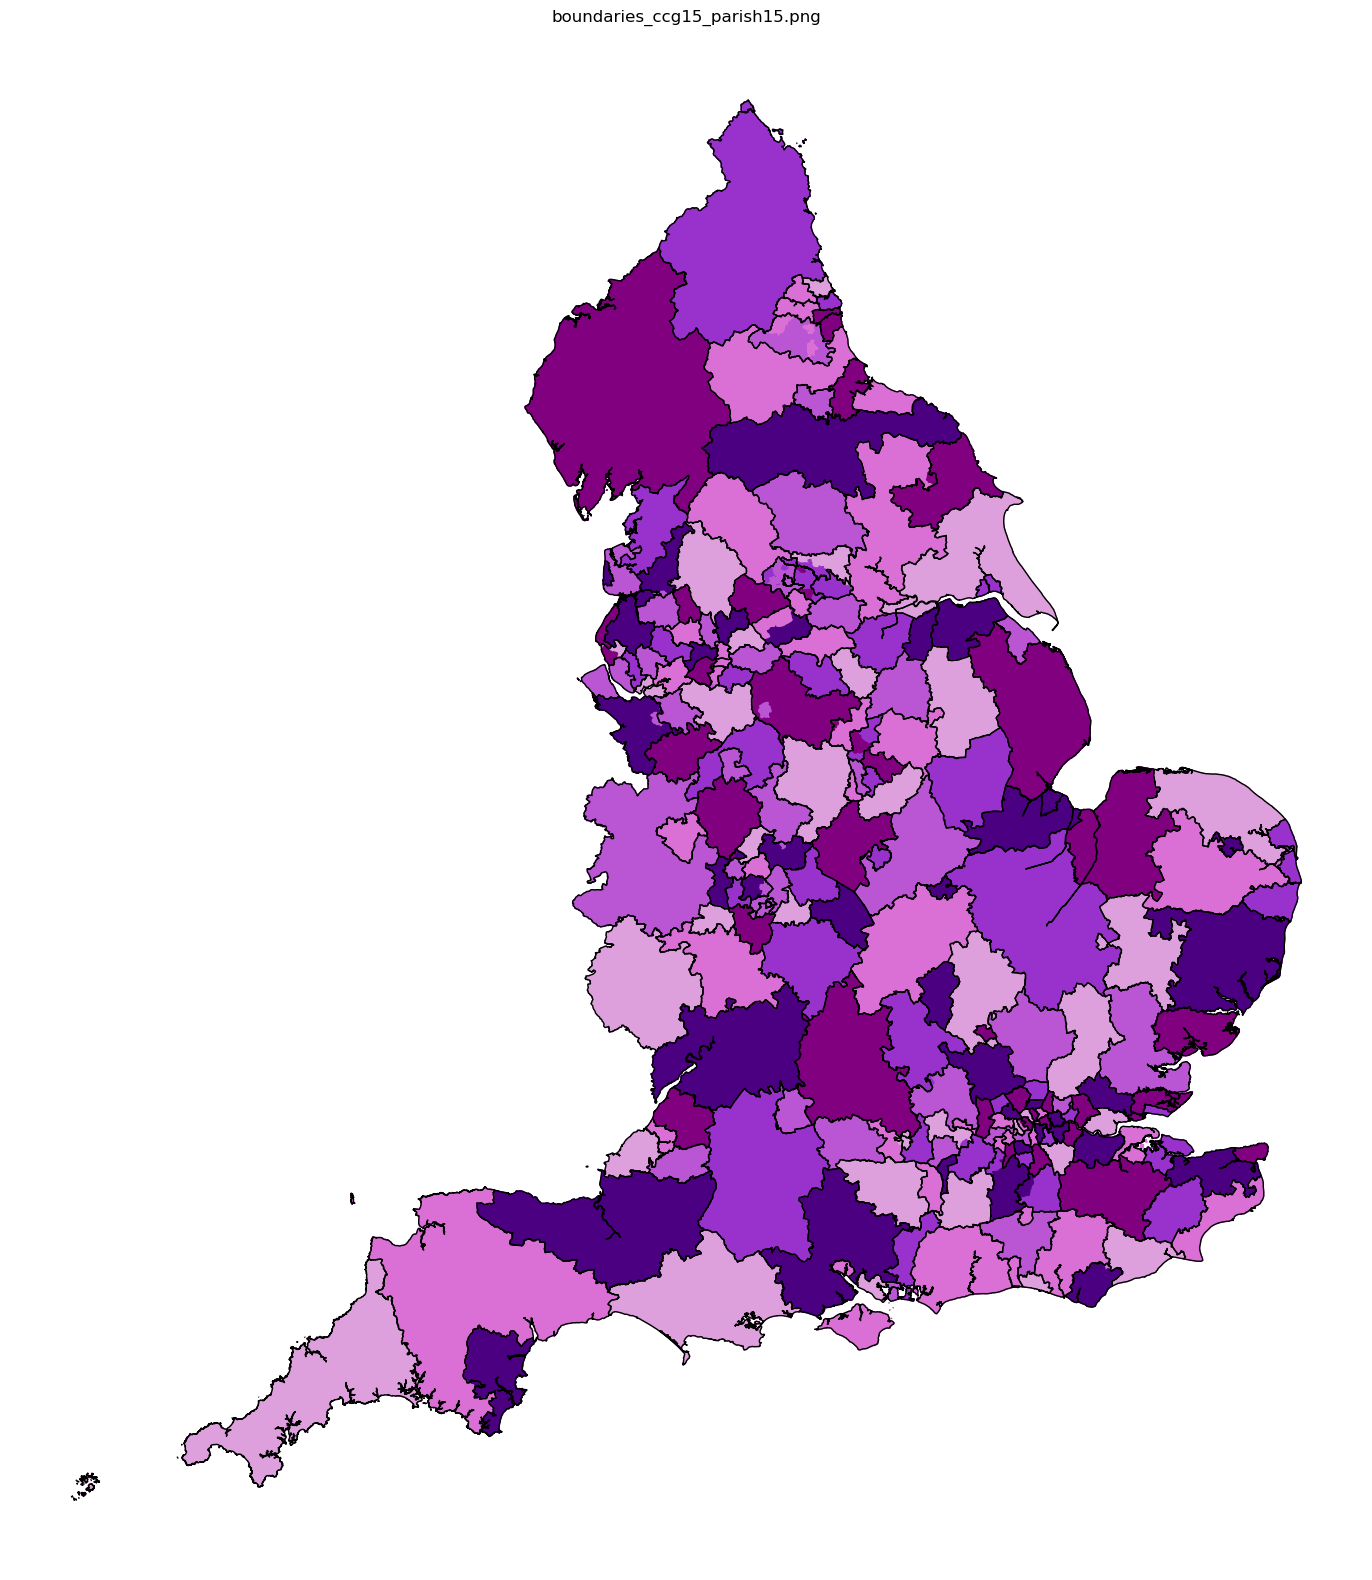

In [9]:
fig, ax = plt.subplots(figsize=(20, 20))

gdf_parish15_for_map.plot(ax=ax, edgecolor='face', facecolor=gdf_parish15_for_map['colour_str'])
gdf_ccg15_for_map.plot(ax=ax, edgecolor='k', facecolor='none')

ax.axis('off')
ax.set_title(paths.image_ccg15_parish15)

plt.savefig(os.path.join(paths.dir_output_images, paths.image_ccg15_parish15), bbox_inches='tight')
plt.show()

### Census-mean Wards 2011 vs CCG 2015

Import region files:

In [10]:
gdf_cmward11 = geopandas.read_file(os.path.join(paths.dir_ons_geojson, paths.cmward11_geojson))

In [11]:
gdf_ccg15 = geopandas.read_file(os.path.join(paths.dir_ons_geojson, paths.ccg15_geojson))

In [12]:
gdf_cmward11.head(3)

,OBJECTID,cmwd11cd,cmwd11nm,cmwd11nmw,lad11cd,lad11nm,lad11nmw,GlobalID,geometry
0,1,E36000001,Brus,,E06000001,Hartlepool,,5140fa27-4510-422d-8381-c1cbd2bb4d58,"POLYGON ((451002.399 535163.000, 450871.100 53..."
1,2,E36000002,Burn Valley,,E06000001,Hartlepool,,3eb5ef96-8689-485e-a50c-a1934765e018,"POLYGON ((450358.899 532312.199, 450393.299 53..."
2,3,E36000003,Dyke House,,E06000001,Hartlepool,,39e2dc71-e7e5-420e-bf8f-cb288a1d0bc2,"POLYGON ((450629.700 533989.900, 450865.800 53..."


In [13]:
gdf_ccg15.head(3)

,OBJECTID,ccg15cd,ccg15nm,GlobalID,geometry
0,1,E38000001,"NHS Airedale, Wharfedale and Craven CCG",9c545200-287f-46cb-aae9-b7dbd4864dd1,"POLYGON ((385705.500 483950.594, 386027.000 48..."
1,2,E38000002,NHS Ashford CCG,7cb0f335-98b9-4002-93ee-e16a1311439d,"POLYGON ((606227.312 156491.141, 606452.622 15..."
2,3,E38000003,NHS Aylesbury Vale CCG,92a2301c-8bc6-44a4-b09d-0995f98d4fbc,"POLYGON ((472439.907 242170.703, 472451.406 24..."


In [14]:
gdf_ccg15_for_map, gdf_cmward11_for_map = prepare_data_for_maps(
    gdf_ccg15,
    gdf_cmward11,
    'ccg15cd',
    'cmwd11cd'
)

/tmp/ipykernel_30022/292196009.py:13: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gdf_small_regions = gdf_small_regions.explode()


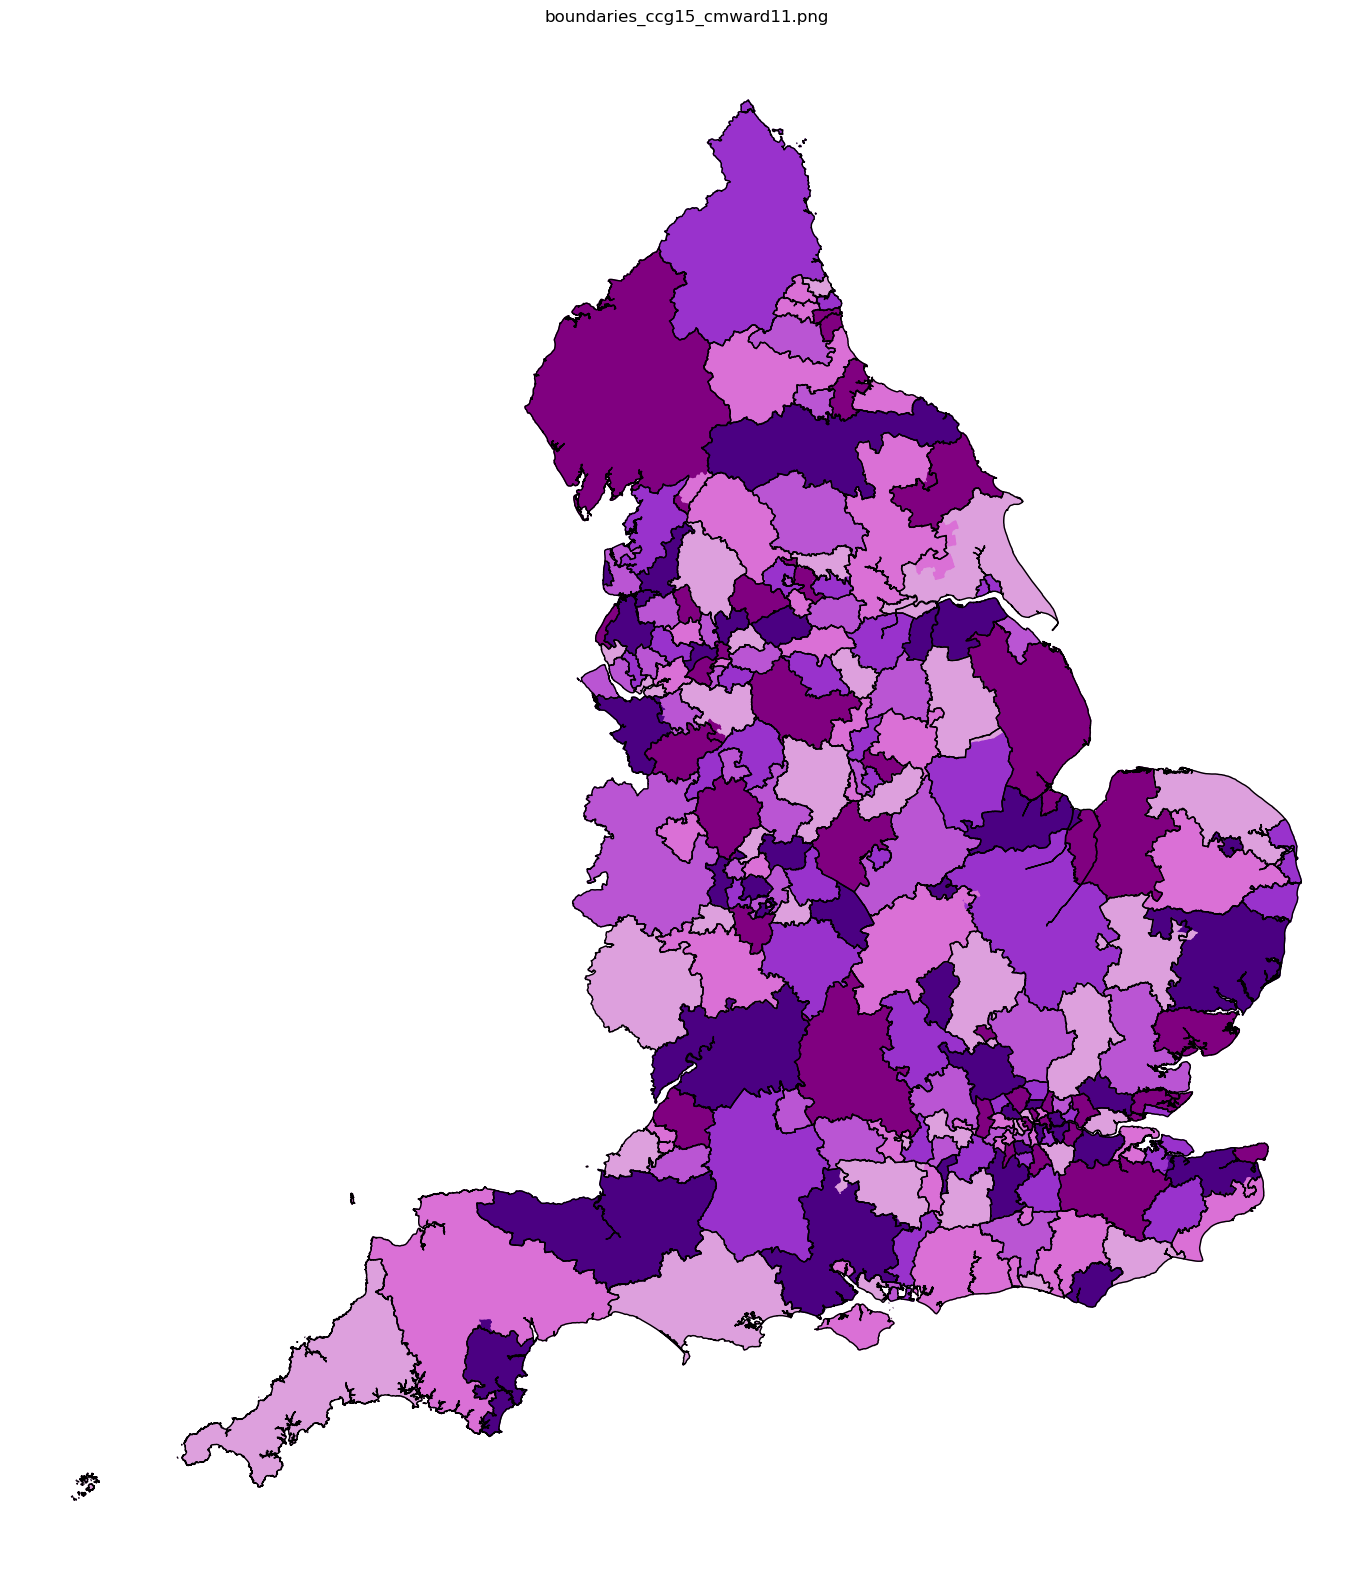

In [15]:
fig, ax = plt.subplots(figsize=(20, 20))

gdf_cmward11_for_map.plot(ax=ax, edgecolor='face', facecolor=gdf_cmward11_for_map['colour_str'])
gdf_ccg15_for_map.plot(ax=ax, edgecolor='k', facecolor='none')

ax.axis('off')
ax.set_title(paths.image_ccg15_cmward11)

plt.savefig(os.path.join(paths.dir_output_images, paths.image_ccg15_cmward11), bbox_inches='tight')
plt.show()

### Wards 2011 vs CCG 2015

Import region files:

In [16]:
gdf_ward11 = geopandas.read_file(os.path.join(paths.dir_ons_geojson, paths.ward11_geojson))

In [17]:
gdf_ccg15 = geopandas.read_file(os.path.join(paths.dir_ons_geojson, paths.ccg15_geojson))

In [18]:
gdf_ward11.head(3)

,OBJECTID,wd11cd,wd11cdo,wd11nm,wd11nmw,GlobalID,geometry
0,1,E05000001,00AAFA,Aldersgate,,64cb20c8-32b0-4f08-a116-95ffd53af4eb,"POLYGON ((532248.300 181560.301, 532207.201 18..."
1,2,E05000002,00AAFB,Aldgate,,97f04007-2afc-4c5f-97cf-ef203a026f55,"POLYGON ((533470.100 181404.800, 533617.699 18..."
2,3,E05000003,00AAFC,Bassishaw,,c0ea55b2-fe08-42b8-9c1d-3ae222d60654,"POLYGON ((532544.799 181629.599, 532656.599 18..."


In [19]:
gdf_ccg15.head(3)

,OBJECTID,ccg15cd,ccg15nm,GlobalID,geometry
0,1,E38000001,"NHS Airedale, Wharfedale and Craven CCG",9c545200-287f-46cb-aae9-b7dbd4864dd1,"POLYGON ((385705.500 483950.594, 386027.000 48..."
1,2,E38000002,NHS Ashford CCG,7cb0f335-98b9-4002-93ee-e16a1311439d,"POLYGON ((606227.312 156491.141, 606452.622 15..."
2,3,E38000003,NHS Aylesbury Vale CCG,92a2301c-8bc6-44a4-b09d-0995f98d4fbc,"POLYGON ((472439.907 242170.703, 472451.406 24..."


In [20]:
gdf_ccg15_for_map, gdf_ward11_for_map = prepare_data_for_maps(
    gdf_ccg15,
    gdf_ward11,
    'ccg15cd',
    'wd11cd'
)

/tmp/ipykernel_30022/292196009.py:13: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gdf_small_regions = gdf_small_regions.explode()


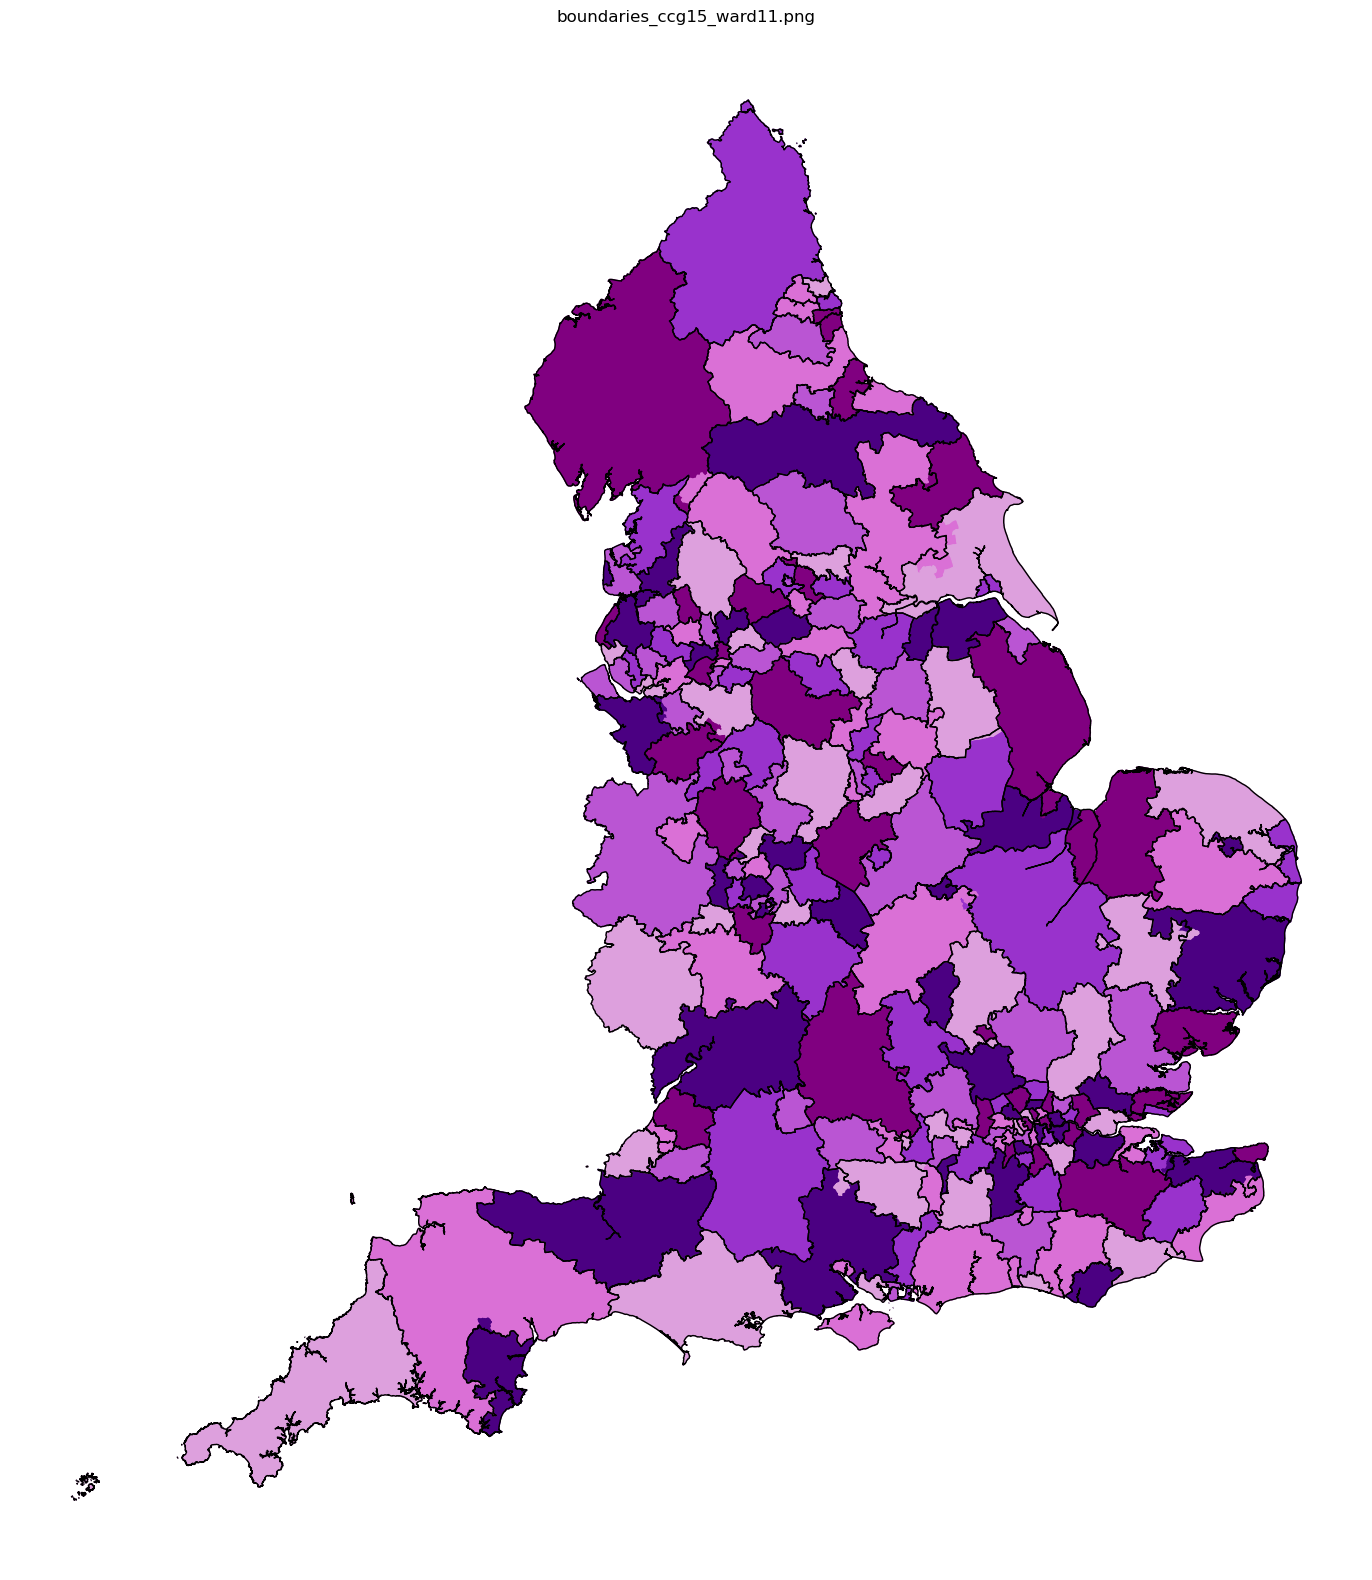

In [21]:
fig, ax = plt.subplots(figsize=(20, 20))

gdf_ward11_for_map.plot(ax=ax, edgecolor='face', facecolor=gdf_ward11_for_map['colour_str'])
gdf_ccg15_for_map.plot(ax=ax, edgecolor='k', facecolor='none')

ax.axis('off')
ax.set_title(paths.image_ccg15_ward11)

plt.savefig(os.path.join(paths.dir_output_images, paths.image_ccg15_ward11), bbox_inches='tight')
plt.show()

### Wards 2015 vs CCG 2015

Import region files:

In [22]:
gdf_ward15 = geopandas.read_file(os.path.join(paths.dir_ons_geojson, paths.ward15_geojson))

In [23]:
gdf_ccg15 = geopandas.read_file(os.path.join(paths.dir_ons_geojson, paths.ccg15_geojson))

In [24]:
gdf_ward15.head(3)

,OBJECTID,wd15cd,wd15nm,wd15nmw,lad15cd,lad15nm,GlobalID,geometry
0,1,E05000026,Abbey,,E09000002,Barking and Dagenham,b55abda8-bb09-4aea-91df-74ee7ae09083,"MULTIPOLYGON (((545296.400 184162.600, 545000...."
1,2,E05000027,Alibon,,E09000002,Barking and Dagenham,aa5baa80-2d89-431a-88b6-f7c801d8fcd1,"POLYGON ((549049.300 184708.300, 548518.700 18..."
2,3,E05000028,Becontree,,E09000002,Barking and Dagenham,d1b8ddf2-0be3-4df4-9e80-6c30f38d38c9,"POLYGON ((546209.400 185783.600, 546267.500 18..."


In [25]:
gdf_ccg15.head(3)

,OBJECTID,ccg15cd,ccg15nm,GlobalID,geometry
0,1,E38000001,"NHS Airedale, Wharfedale and Craven CCG",9c545200-287f-46cb-aae9-b7dbd4864dd1,"POLYGON ((385705.500 483950.594, 386027.000 48..."
1,2,E38000002,NHS Ashford CCG,7cb0f335-98b9-4002-93ee-e16a1311439d,"POLYGON ((606227.312 156491.141, 606452.622 15..."
2,3,E38000003,NHS Aylesbury Vale CCG,92a2301c-8bc6-44a4-b09d-0995f98d4fbc,"POLYGON ((472439.907 242170.703, 472451.406 24..."


In [26]:
gdf_ccg15_for_map, gdf_ward15_for_map = prepare_data_for_maps(
    gdf_ccg15,
    gdf_ward15,
    'ccg15cd',
    'wd15cd'
)

/tmp/ipykernel_30022/292196009.py:13: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gdf_small_regions = gdf_small_regions.explode()


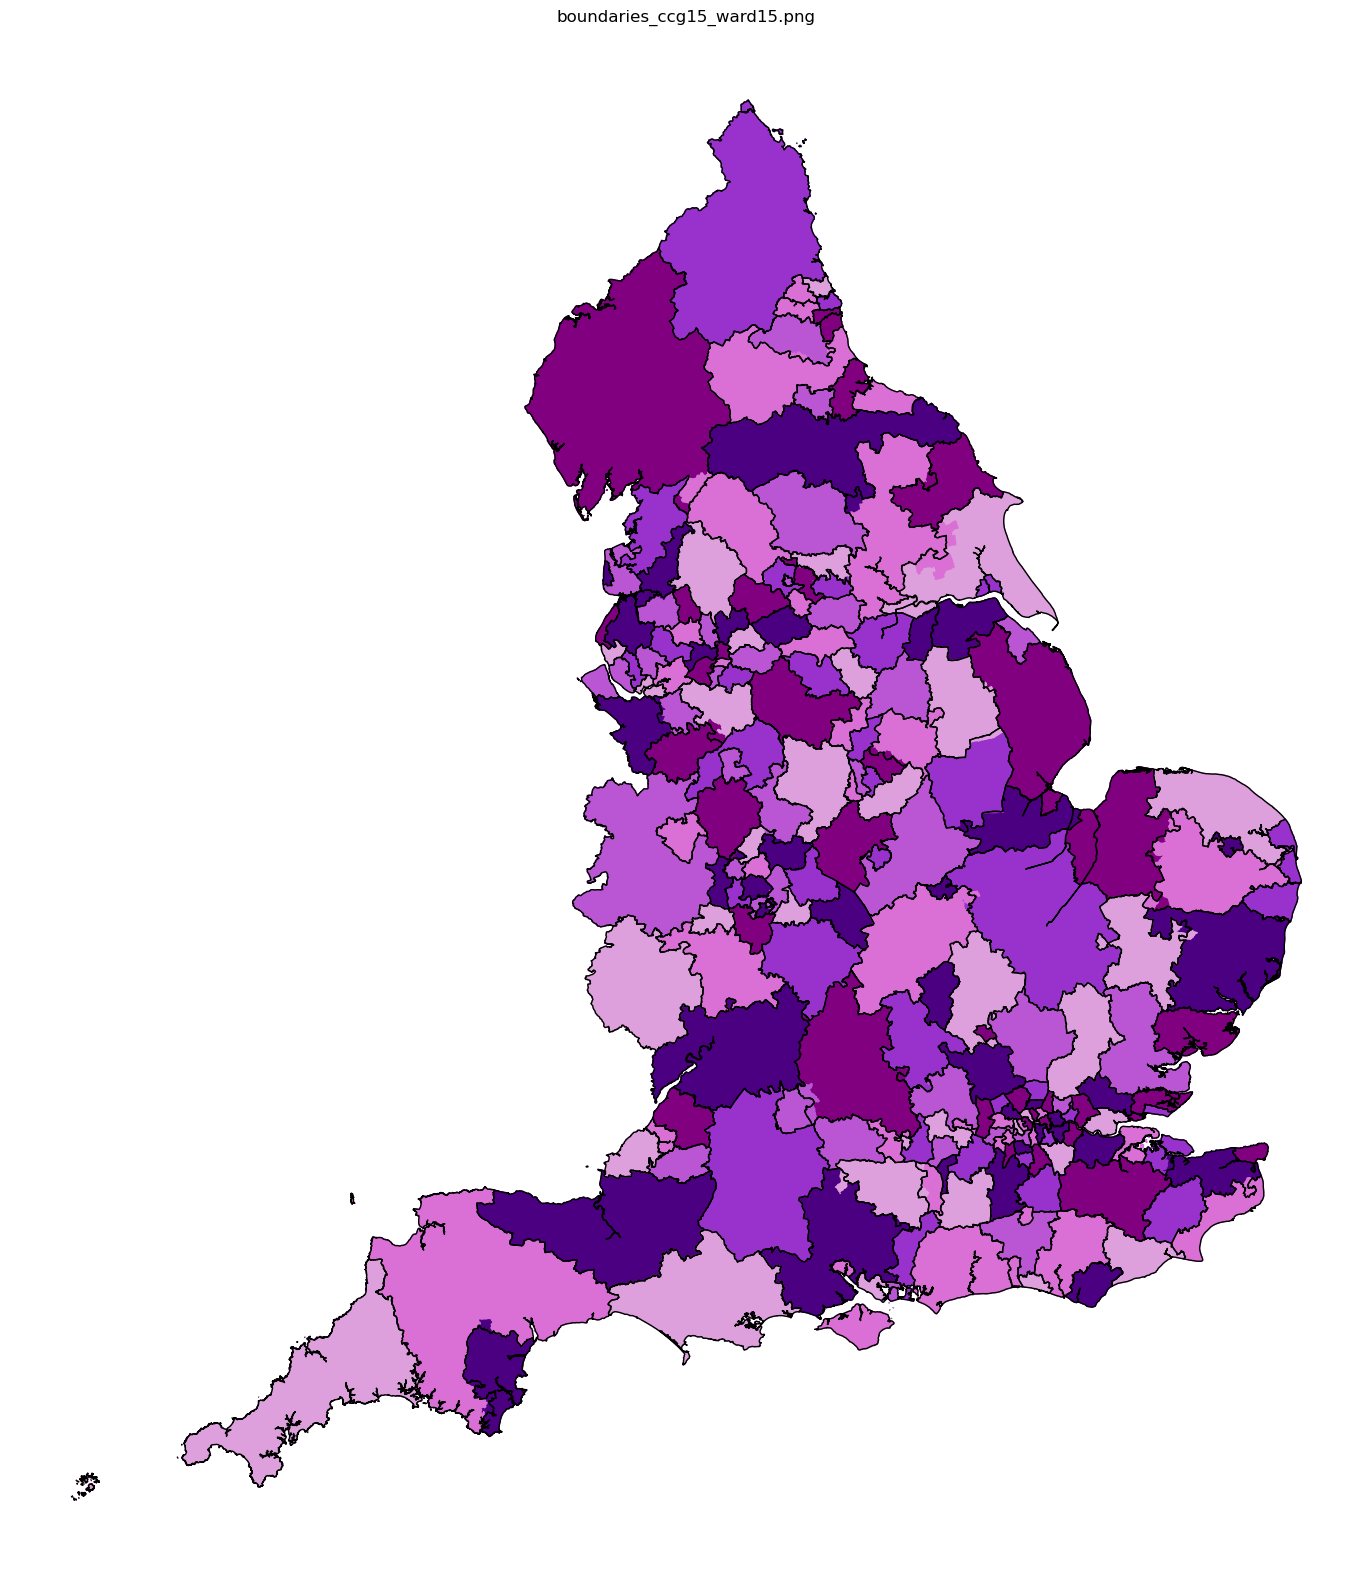

In [27]:
fig, ax = plt.subplots(figsize=(20, 20))

gdf_ward15_for_map.plot(ax=ax, edgecolor='face', facecolor=gdf_ward15_for_map['colour_str'])
gdf_ccg15_for_map.plot(ax=ax, edgecolor='k', facecolor='none')

ax.axis('off')
ax.set_title(paths.image_ccg15_ward15)

plt.savefig(os.path.join(paths.dir_output_images, paths.image_ccg15_ward15), bbox_inches='tight')
plt.show()

### Ward 2021 vs SICBL 2022

Import region files:

In [28]:
gdf_ward21 = geopandas.read_file(os.path.join(paths.dir_ons_geojson, paths.ward21_geojson))

In [29]:
gdf_sicbl22 = geopandas.read_file(os.path.join(paths.dir_ons_geojson, paths.sicbl22_geojson))

In [30]:
gdf_sicbl22.head(3)

,SICBL22CD,SICBL22NM,BNG_E,BNG_N,LONG,LAT,OBJECTID,GlobalID,geometry
0,E38000006,NHS South Yorkshire ICB - 02P,429979,403330,-1.549250,53.52580,1,32649d0f-f9d3-4108-a109-0fea4cd3af00,"POLYGON ((443219.660 409833.090, 443286.853 40..."
1,E38000007,NHS Mid and South Essex ICB - 99E,564014,194421,0.368068,51.62470,2,f8f0102e-9c60-42ef-980d-cb0c67b4b161,"MULTIPOLYGON (((576454.010 184830.650, 576417...."
2,E38000008,NHS Nottingham and Nottinghamshire ICB - 02Q,468073,384833,-0.978700,53.35602,3,358ec7e7-3a4c-4f5c-b51f-cffa8666f71e,"MULTIPOLYGON (((482031.031 373911.312, 482015...."


In [31]:
gdf_ward21.head(3)

,OBJECTID,WD21CD,WD21NM,WD21NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
0,1,E05000026,Abbey,,544433,184376,0.081276,51.5398,fb5afce3-bcc7-48c0-ba4b-25a1be545316,"MULTIPOLYGON (((543577.234 183950.569, 543520...."
1,2,E05000027,Alibon,,549247,185196,0.150987,51.5459,81870c0a-d87a-4337-8216-a9ba21a7d792,"POLYGON ((549604.103 185773.202, 549620.304 18..."
2,3,E05000028,Becontree,,546860,185870,0.116869,51.5526,015b4c1a-431f-4d3b-8f44-661adde997aa,"POLYGON ((547563.400 186223.903, 547418.098 18..."


In [32]:
gdf_sicbl22_for_map, gdf_ward21_for_map = prepare_data_for_maps(
    gdf_sicbl22,
    gdf_ward21,
    'SICBL22CD',
    'WD21CD'
)

/tmp/ipykernel_30022/292196009.py:13: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gdf_small_regions = gdf_small_regions.explode()


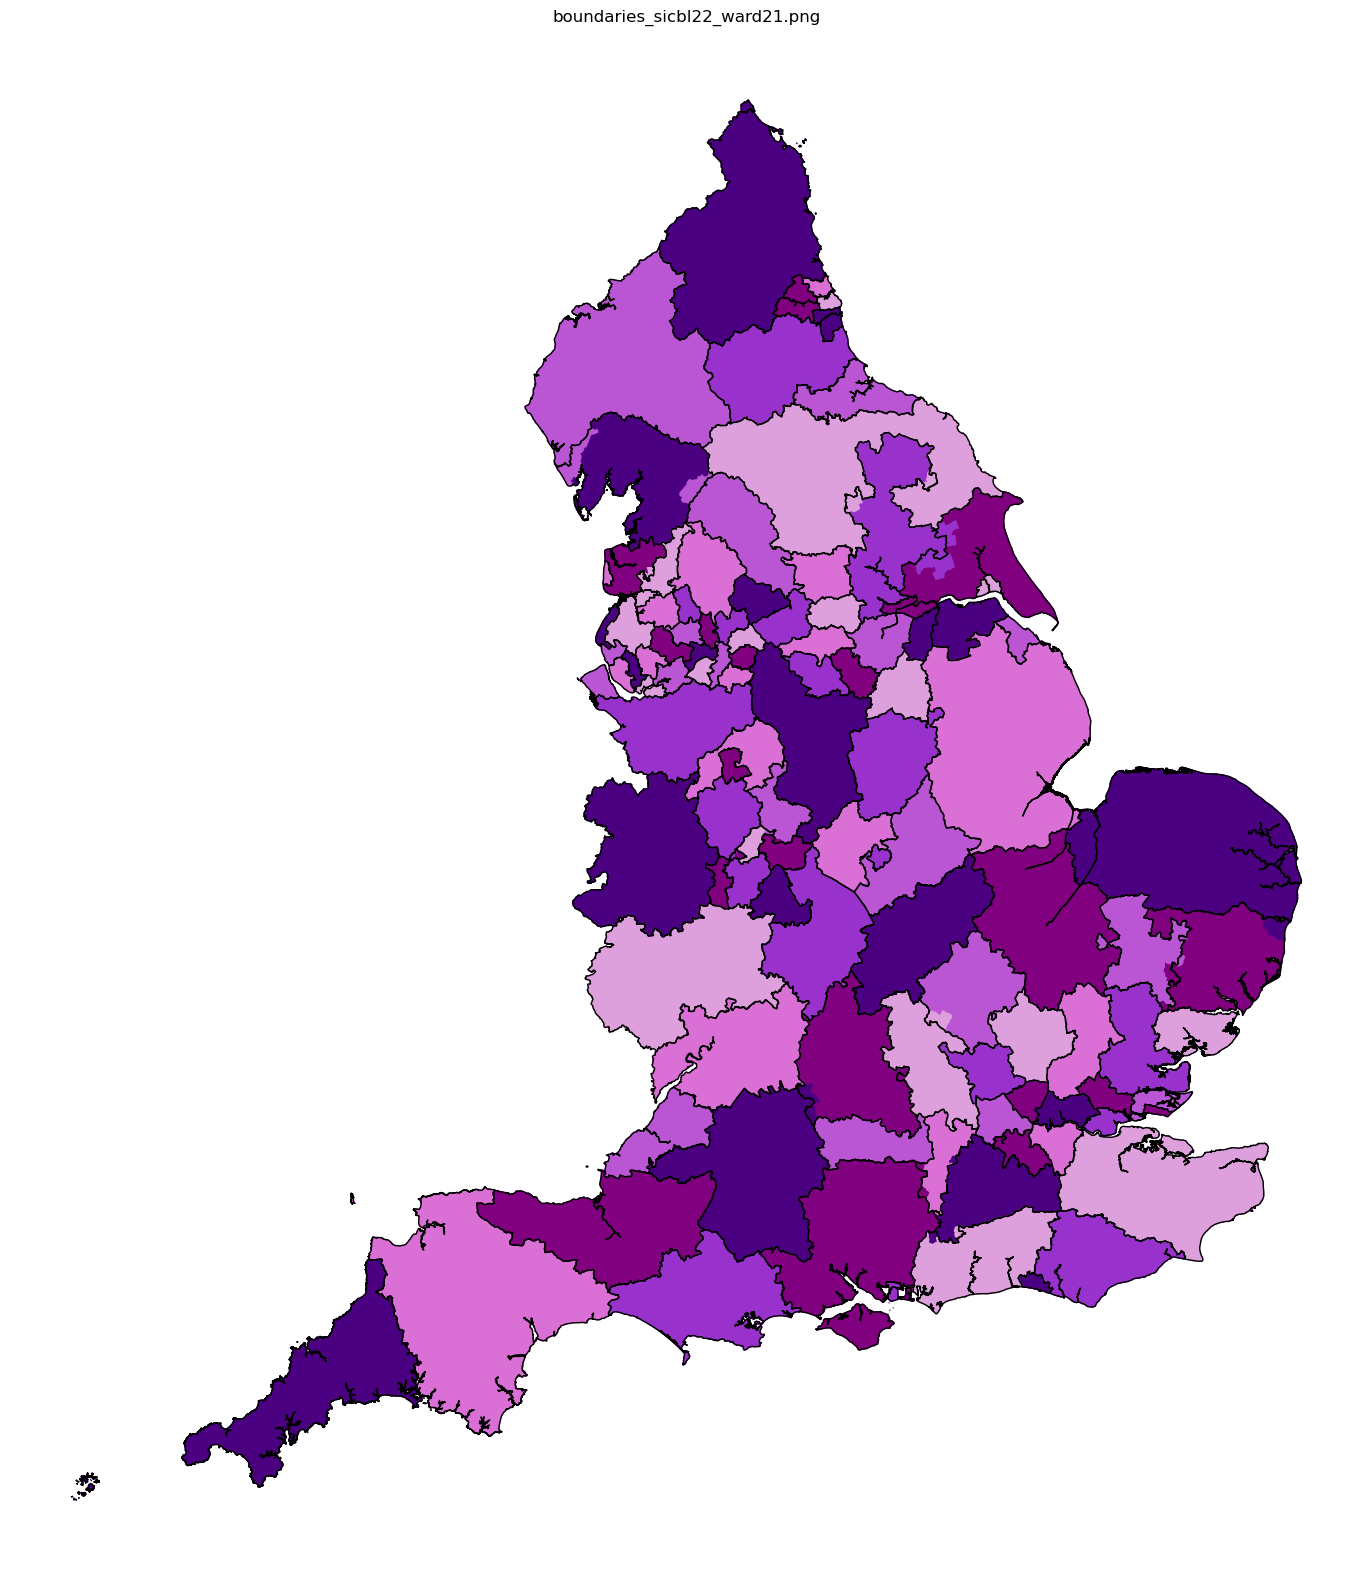

In [33]:
fig, ax = plt.subplots(figsize=(20, 20))

gdf_ward21_for_map.plot(ax=ax, edgecolor='face', facecolor=gdf_ward21_for_map['colour_str'])
gdf_sicbl22_for_map.plot(ax=ax, edgecolor='k', facecolor='none')

ax.axis('off')
ax.set_title(paths.image_sicbl22_ward21)

plt.savefig(os.path.join(paths.dir_output_images, paths.image_sicbl22_ward21), bbox_inches='tight')
plt.show()

### Parish 2020 vs SICBL 2022

Import region files:

In [34]:
gdf_parish20 = geopandas.read_file(os.path.join(paths.dir_ons_geojson, paths.parish20_geojson))

In [35]:
gdf_sicbl22 = geopandas.read_file(os.path.join(paths.dir_ons_geojson, paths.sicbl22_geojson))

In [36]:
gdf_sicbl22.head(3)

,SICBL22CD,SICBL22NM,BNG_E,BNG_N,LONG,LAT,OBJECTID,GlobalID,geometry
0,E38000006,NHS South Yorkshire ICB - 02P,429979,403330,-1.549250,53.52580,1,32649d0f-f9d3-4108-a109-0fea4cd3af00,"POLYGON ((443219.660 409833.090, 443286.853 40..."
1,E38000007,NHS Mid and South Essex ICB - 99E,564014,194421,0.368068,51.62470,2,f8f0102e-9c60-42ef-980d-cb0c67b4b161,"MULTIPOLYGON (((576454.010 184830.650, 576417...."
2,E38000008,NHS Nottingham and Nottinghamshire ICB - 02Q,468073,384833,-0.978700,53.35602,3,358ec7e7-3a4c-4f5c-b51f-cffa8666f71e,"MULTIPOLYGON (((482031.031 373911.312, 482015...."


In [37]:
gdf_parish20.head(3)

,OBJECTID,PARNCP20CD,PARNCP20NM,PARNCP20NW,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
0,1,E04000001,Blackrod,,361020,410662,-2.59036,53.59109,40ab0254-aadf-423d-becb-5d307558c4cf,"POLYGON ((360732.303 412845.704, 360831.499 41..."
1,2,E04000002,Horwich,,365741,411963,-2.51919,53.60311,a73799df-b5aa-445e-9bc7-ec72661680e2,"POLYGON ((366340.404 414544.797, 366110.597 41..."
2,3,E04000003,Westhoughton,,365008,406179,-2.52961,53.55108,cbacc002-a251-49c0-9a72-46402a5f4d8c,"POLYGON ((366943.596 404722.699, 366815.097 40..."


In [38]:
gdf_sicbl22_for_map, gdf_parish20_for_map = prepare_data_for_maps(
    gdf_sicbl22,
    gdf_parish20,
    'SICBL22CD',
    'PARNCP20CD'
)

/tmp/ipykernel_30022/292196009.py:13: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gdf_small_regions = gdf_small_regions.explode()


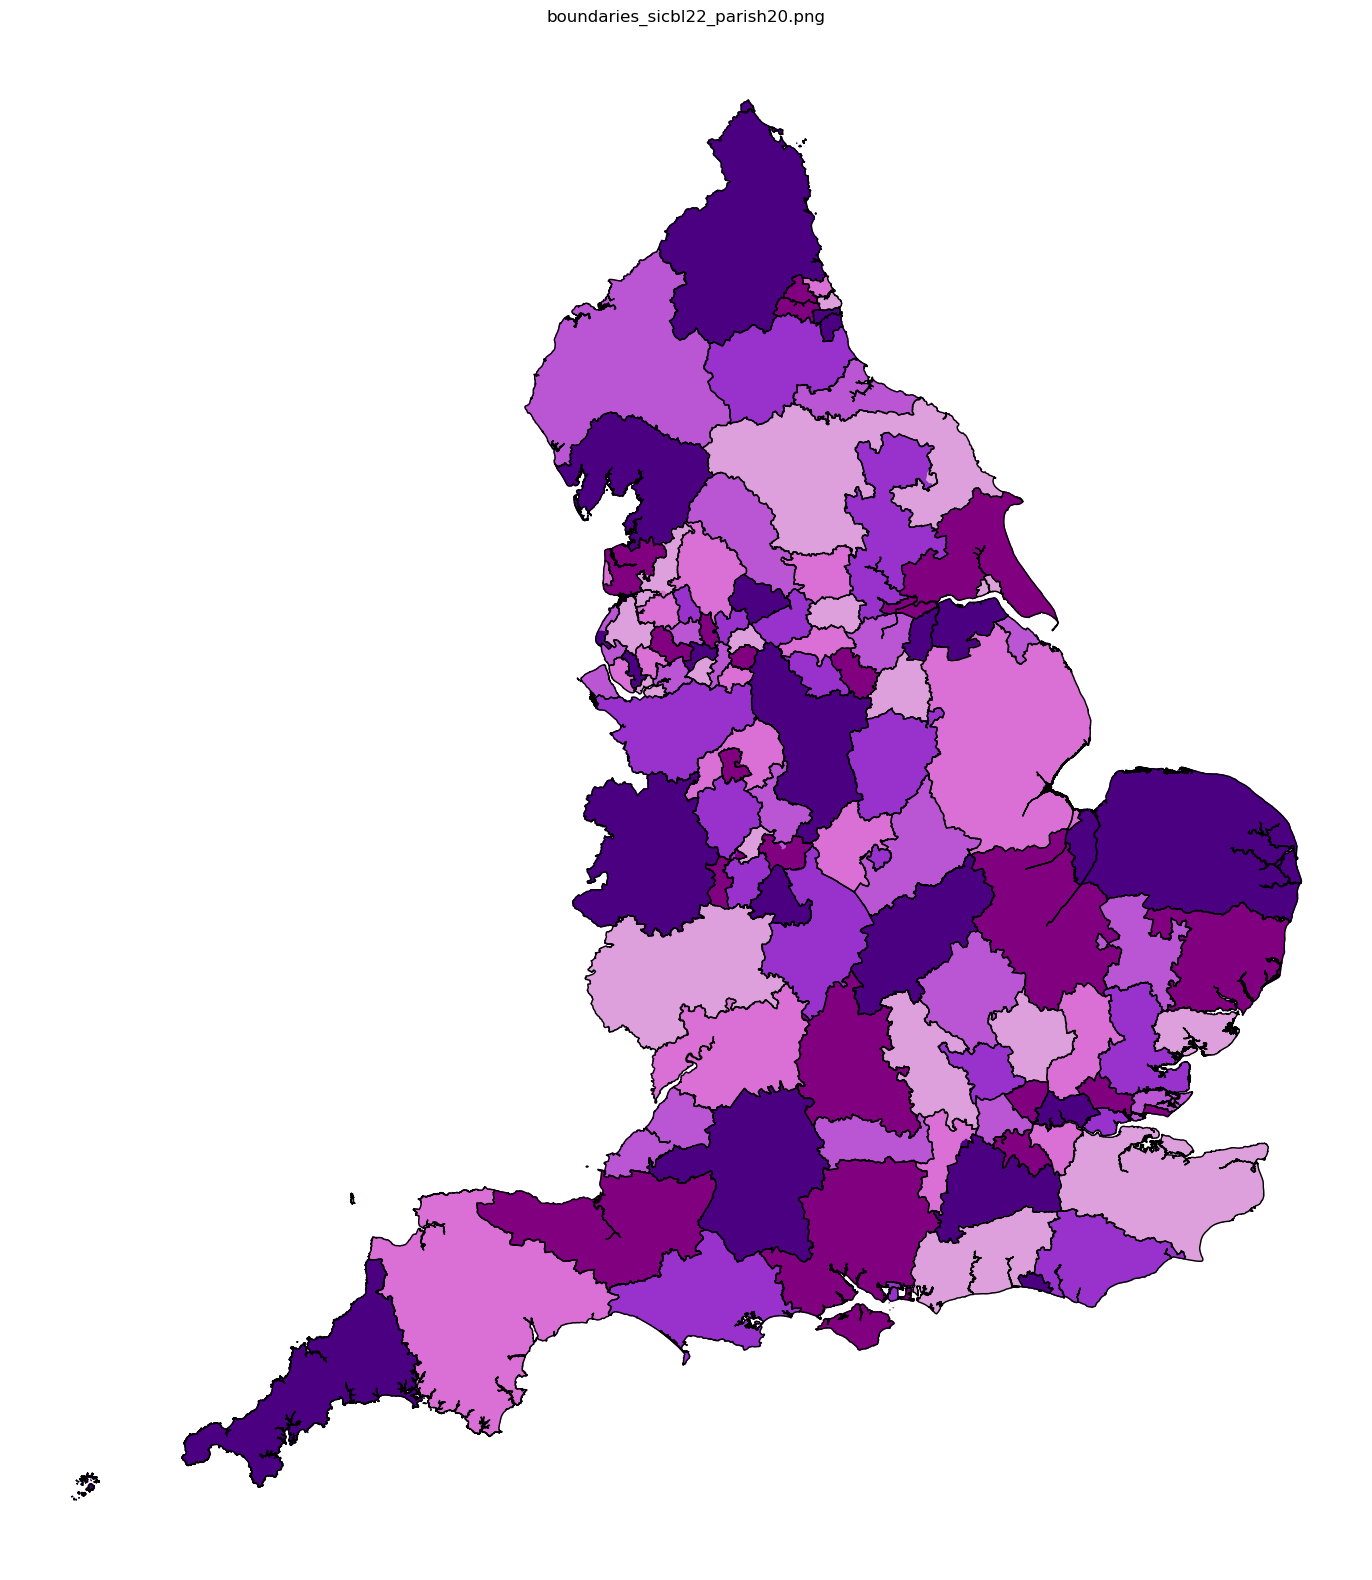

In [39]:
fig, ax = plt.subplots(figsize=(20, 20))

gdf_parish20_for_map.plot(ax=ax, edgecolor='face', facecolor=gdf_parish20_for_map['colour_str'])
gdf_sicbl22_for_map.plot(ax=ax, edgecolor='k', facecolor='none')

ax.axis('off')
ax.set_title(paths.image_sicbl22_parish20)

plt.savefig(os.path.join(paths.dir_output_images, paths.image_sicbl22_parish20), bbox_inches='tight')
plt.show()

### LSOA with similar names vs CCG

In [40]:
gdf_lsoa11 = geopandas.read_file(os.path.join(paths.dir_ons_geojson, paths.lsoa11_geojson))
gdf_ccg15 = geopandas.read_file(os.path.join(paths.dir_ons_geojson, paths.ccg15_geojson))

In [41]:
gdf_ccg15.head(3)

,OBJECTID,ccg15cd,ccg15nm,GlobalID,geometry
0,1,E38000001,"NHS Airedale, Wharfedale and Craven CCG",9c545200-287f-46cb-aae9-b7dbd4864dd1,"POLYGON ((385705.500 483950.594, 386027.000 48..."
1,2,E38000002,NHS Ashford CCG,7cb0f335-98b9-4002-93ee-e16a1311439d,"POLYGON ((606227.312 156491.141, 606452.622 15..."
2,3,E38000003,NHS Aylesbury Vale CCG,92a2301c-8bc6-44a4-b09d-0995f98d4fbc,"POLYGON ((472439.907 242170.703, 472451.406 24..."


In [42]:
gdf_lsoa11.head(3)

,FID,LSOA11CD,LSOA11NM,LSOA11NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
0,1,E01000001,City of London 001A,City of London 001A,532129,181625,-0.09706,51.51810,283b0ead-f8fc-40b6-9a79-1ddd7e5c0758,"POLYGON ((532105.092 182011.231, 532162.491 18..."
1,2,E01000002,City of London 001B,City of London 001B,532480,181699,-0.09197,51.51868,ddce266b-7825-428c-9e0a-df66b0179a55,"POLYGON ((532634.497 181926.016, 532619.141 18..."
2,3,E01000003,City of London 001C,City of London 001C,532245,182036,-0.09523,51.52176,c45e358e-a794-485a-bf76-d96e5d458ea4,"POLYGON ((532135.138 182198.131, 532158.250 18..."


Glob together LSOA with similar names:

In [43]:
lsoa_name_bits = gdf_lsoa11['LSOA11NM'].str.split(' ').to_list()

lsoa_name_bits_without_numbers = [' '.join(bits[:-1]) for bits in lsoa_name_bits]

gdf_lsoa11['lsoa_name_without_numbers'] = lsoa_name_bits_without_numbers

gdf_lsoa_glob = gdf_lsoa11.dissolve(by='lsoa_name_without_numbers').reset_index()

Continue the function as usual:

In [44]:
gdf_ccg15_for_map, gdf_lsoa_glob_for_map = prepare_data_for_maps(
    gdf_ccg15,
    gdf_lsoa_glob,
    'ccg15cd',
    'lsoa_name_without_numbers'
)

/tmp/ipykernel_30022/292196009.py:13: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gdf_small_regions = gdf_small_regions.explode()


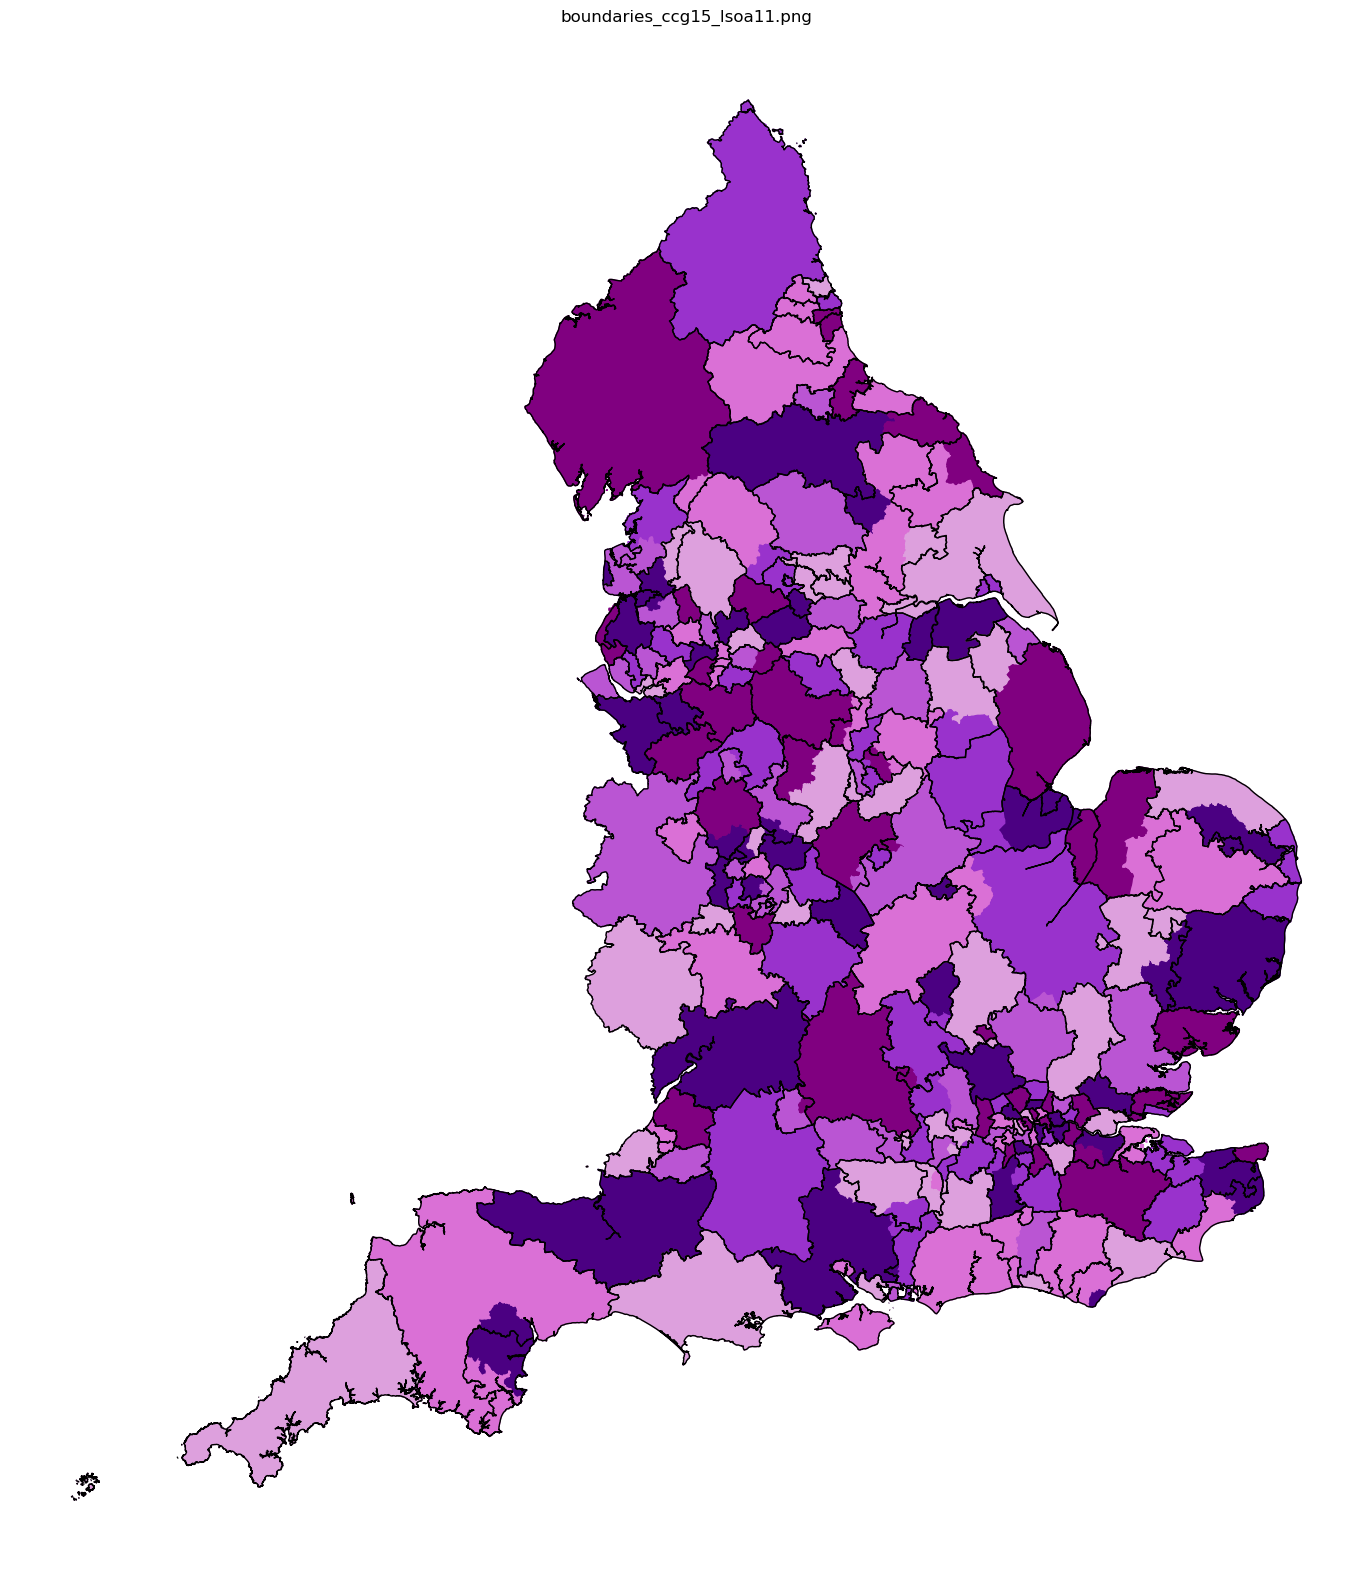

In [45]:
fig, ax = plt.subplots(figsize=(20, 20))

gdf_lsoa_glob_for_map.plot(ax=ax, edgecolor='face', facecolor=gdf_lsoa_glob_for_map['colour_str'])
gdf_ccg15_for_map.plot(ax=ax, edgecolor='k', facecolor='none')

ax.axis('off')
ax.set_title(paths.image_ccg15_lsoa11)

plt.savefig(os.path.join(paths.dir_output_images, paths.image_ccg15_lsoa11), bbox_inches='tight')
plt.show()